# Train a regression ConvNN model using BOHB tuner

In [1]:
import sys  
sys.path.insert(0, '../telescopeML/')

from ObservPredictor import ProcessObservationalDataset, ObsParameterPredictor
from DeepRegTrainer import TrainRegression
from StatVisAnalyzer import *

# from functions import plot_predicted_vs_observed, boxplot_hist, plot_spectra_errorbar, plot_predicted_vs_spectra_errorbar
# from functions import filter_dataframe, interpolate_df, find_nearest_top_bottom, filter_dataset_range, regression_report, print_results_fun


2023-07-15 12:49:56.930381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

Loading BokehJS ...

# Step 1: Load the dataset

In [2]:
# original dataset
df=pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
df.head(3)

gravity  temperature  c_o_ratio  metallicity         2.512         2.487  \
0      5.0         1100       0.25         -1.0  9.103045e-08  1.181658e-07   
1      5.0         1100       0.25         -0.7  9.103045e-08  1.181658e-07   
2      5.0         1100       0.25         -0.5  9.103045e-08  1.181658e-07   

          2.462         2.438         2.413         2.389  ...         0.971  \
0  1.307868e-07  1.269229e-07  1.159179e-07  8.925110e-08  ...  9.640859e-08   
1  1.307868e-07  1.269229e-07  1.159179e-07  8.925110e-08  ...  9.640859e-08   
2  1.307868e-07  1.269229e-07  1.159179e-07  8.925110e-08  ...  9.640859e-08   

          0.962         0.952         0.943         0.933         0.924  \
0  7.612550e-08  6.901364e-08  6.247359e-08  4.112384e-08  5.127995e-08   
1  7.612550e-08  6.901364e-08  6.247359e-08  4.112384e-08  5.127995e-08   
2  7.612550e-08  6.901364e-08  6.247359e-08  4.112384e-08  5.127995e-08   

          0.915         0.906         0.897  is_augmented  
0  4.897355e-08  4.087795e-08  2.791689e-08            no  
1  4.897355e-08  4.087795e-08  2.791689e-08            no  
2  4.897355e-08  4.087795e-08  2.791689e-08            no  

[3 rows x 109 columns]

In [3]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

wl
0  2.511960
1  2.486966
2  2.462220

In [4]:
df.iloc[::10]

gravity  temperature  c_o_ratio  metallicity         2.512  \
0         5.00         1100       0.25         -1.0  9.103045e-08   
10        5.00         1100       0.25          1.7  8.540979e-09   
20        5.00         1100       0.50          1.0  2.089233e-08   
30        5.00         1100       1.00          0.5  3.773544e-08   
40        5.00         1100       1.50          0.0  7.403044e-08   
...        ...          ...        ...          ...           ...   
30840     3.25         1000       1.00         -1.0  6.179704e-08   
30850     3.25         1000       1.00          1.7  4.587650e-09   
30860     3.25         1000       1.50          1.0  9.151923e-09   
30870     3.25         1000       2.00          0.5  1.755109e-08   
30880     3.25         1000       2.50          0.0  3.686351e-08   

              2.487         2.462         2.438         2.413         2.389  \
0      1.181658e-07  1.307868e-07  1.269229e-07  1.159179e-07  8.925110e-08   
10     9.610928e-09  8.362026e-09  6.331807e-09  5.411898e-09  3.597492e-09   
20     2.547443e-08  2.398659e-08  1.954245e-08  1.673706e-08  1.128757e-08   
30     4.306029e-08  3.789344e-08  2.982717e-08  2.555826e-08  1.704151e-08   
40     8.240733e-08  7.323895e-08  5.885655e-08  5.086389e-08  3.452053e-08   
...             ...           ...           ...           ...           ...   
30840  6.023661e-08  4.317990e-08  3.128656e-08  2.771920e-08  1.748527e-08   
30850  3.838308e-09  2.586146e-09  1.860407e-09  1.635306e-09  1.152218e-09   
30860  7.599074e-09  4.870096e-09  3.395405e-09  2.993091e-09  2.001870e-09   
30870  1.456820e-08  9.125922e-09  6.253583e-09  5.540055e-09  3.570220e-09   
30880  3.103918e-08  1.962829e-08  1.351563e-08  1.204704e-08  7.567159e-09   

       ...         0.971         0.962         0.952         0.943  \
0      ...  9.640859e-08  7.612550e-08  6.901364e-08  6.247359e-08   
10     ...  2.589948e-09  1.400508e-09  1.423739e-09  1.331622e-09   
20     ...  1.030422e-08  6.744711e-09  6.570654e-09  5.994584e-09   
30     ...  3.370933e-08  2.475817e-08  2.292027e-08  2.084380e-08   
40     ...  1.067845e-07  8.506743e-08  7.629151e-08  6.833675e-08   
...    ...           ...           ...           ...           ...   
30840  ...  6.074206e-08  4.763676e-08  4.974581e-08  4.320090e-08   
30850  ...  1.364340e-09  8.768095e-10  8.903187e-10  7.791423e-10   
30860  ...  8.316857e-09  5.922216e-09  5.734787e-09  5.036230e-09   
30870  ...  3.041929e-08  2.417082e-08  2.437794e-08  2.183006e-08   
30880  ...  8.623869e-08  7.376951e-08  7.271418e-08  6.568662e-08   

              0.933         0.924         0.915         0.906         0.897  \
0      4.112384e-08  5.127995e-08  4.897355e-08  4.087795e-08  2.791689e-08   
10     5.718932e-10  2.525684e-09  2.577776e-09  2.171606e-09  1.170498e-09   
20     3.266539e-09  6.722988e-09  6.756289e-09  5.708415e-09  3.422240e-09   
30     1.293259e-08  1.818421e-08  1.723477e-08  1.401317e-08  8.880054e-09   
40     4.665959e-08  5.297000e-08  4.829532e-08  3.887601e-08  2.587082e-08   
...             ...           ...           ...           ...           ...   
30840  2.942153e-08  4.588604e-08  4.660016e-08  3.899730e-08  2.401752e-08   
30850  4.586279e-10  1.281345e-09  9.366753e-10  5.737637e-10  3.020979e-10   
30860  3.292385e-09  4.859911e-09  3.820969e-09  2.376922e-09  1.196810e-09   
30870  1.552078e-08  1.638151e-08  1.205167e-08  7.349473e-09  3.697040e-09   
30880  4.948854e-08  5.133128e-08  4.178225e-08  2.698869e-08  1.426723e-08   

       is_augmented  
0                no  
10               no  
20               no  
30               no  
40               no  
...             ...  
30840            no  
30850            no  
30860            no  
30870            no  
30880            no  

[3089 rows x 109 columns]

## Prepare feature variables (X) and targets (y)

In [5]:
df = df[df['is_augmented'].isin(['no'])]
X = df.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)

y = df[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [6]:
y['temperature'] = np.log10(y['temperature'])

/tmp/ipykernel_3532/3354840019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['temperature'] = np.log10(y['temperature'])


In [7]:
# print( 'skewness:' )
# display(set( zip(['gravity', 'c_o_ratio', 'metallicity', 'temperature'],(stats.skew(y[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]])))))
# y.hist(grid=True, bins=19);

In [8]:
y.head()

gravity  c_o_ratio  metallicity  temperature
0      5.0       0.25         -1.0     3.041393
1      5.0       0.25         -0.7     3.041393
2      5.0       0.25         -0.5     3.041393
3      5.0       0.25         -0.3     3.041393
4      5.0       0.25          0.0     3.041393

---

# Step 2: Data Processing

In [9]:
# Create an instance of TrainCNNRegression
train_cnn_regression = TrainRegression(feature_values=X,
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             n_jobs=4,
                             cv=5,
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

In [10]:
# Split the dataset into train and test sets
train_cnn_regression.split_train_validation_test(test_size=0.1, val_size=0.1)

In [11]:
# normalize the X features using MinMax Scaler
train_cnn_regression.standardize_X_row_wise()

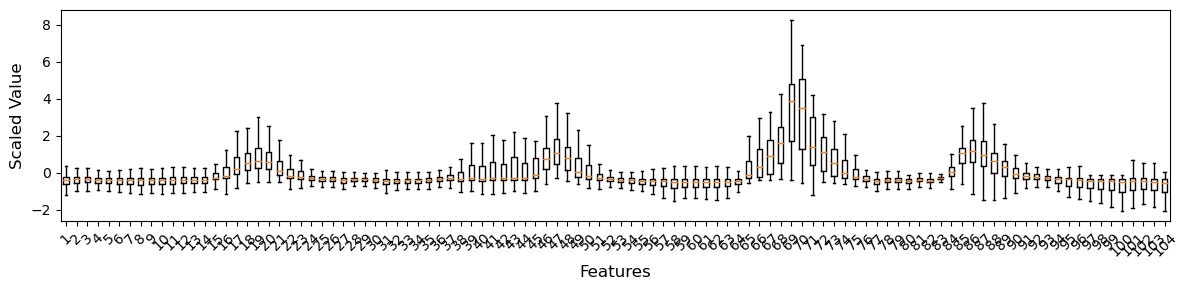

In [12]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_train_standardized_rowwise, xticks_list = None)

In [13]:
# Standardize the y features using Standard Scaler
train_cnn_regression.standardize_y_column_wise()

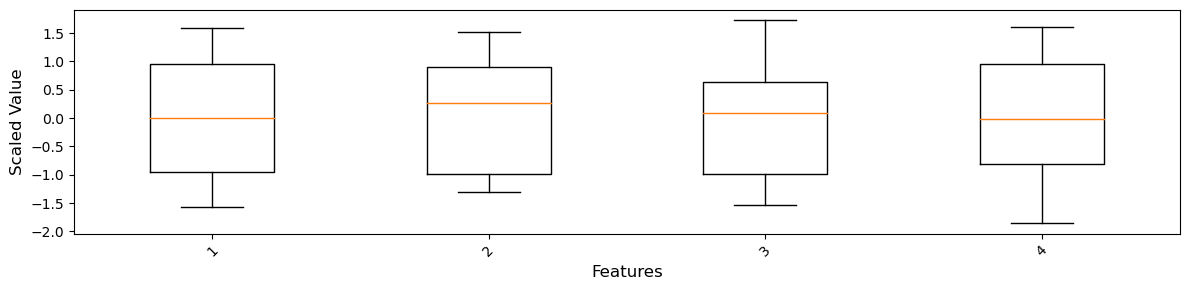

In [14]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.y_train_standardized_columnwise)

In [15]:
# train_cnn_regression.y_train_standardized_columnwise

In [16]:
train_cnn_regression.X_train_min = train_cnn_regression.X_train.min(axis=1)
train_cnn_regression.X_train_max = train_cnn_regression.X_train.max(axis=1)

In [17]:
train_cnn_regression.X_val_min = train_cnn_regression.X_val.min(axis=1)
train_cnn_regression.X_val_max = train_cnn_regression.X_val.max(axis=1)

In [18]:
train_cnn_regression.X_test_min = train_cnn_regression.X_test.min(axis=1)
train_cnn_regression.X_test_max = train_cnn_regression.X_test.max(axis=1)

In [19]:
df_MinMax_train = pd.DataFrame((train_cnn_regression.X_train_min, train_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((train_cnn_regression.X_val_min, train_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((train_cnn_regression.X_test_min, train_cnn_regression.X_test_max)).T

In [20]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [21]:
df_MinMax_train.head()

min           max
28744  8.265340e-12  3.445259e-08
6288   8.080712e-22  8.397132e-14
13749  2.734403e-07  8.632182e-06
11713  4.414951e-16  3.373262e-10
15538  3.722576e-07  6.859888e-06

In [22]:
# plt.loglog(train_cnn_regression.X_train_max, 'k.', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train, 'r.', label='X_train', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train_min, 'r.', alpha = 0.4)

---

In [23]:
train_cnn_regression.standardize_X_column_wise(
                                                X_train = df_MinMax_train.values,
                                                X_val   = df_MinMax_val.values,
                                                X_test  = df_MinMax_test.values,
                                                )

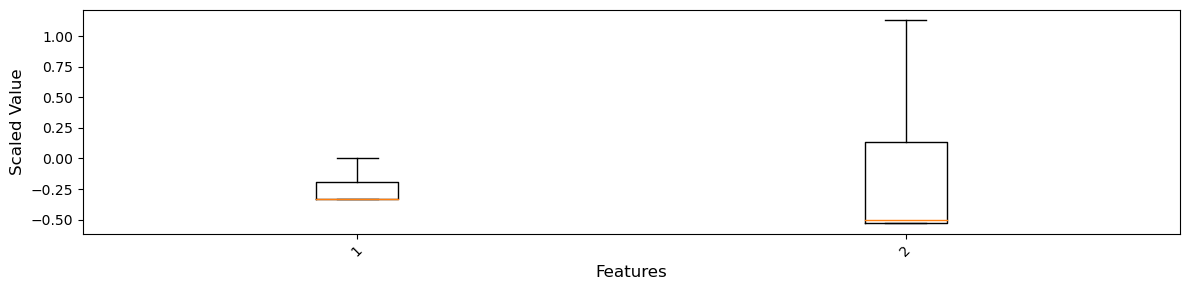

In [24]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_test_standardized_columnwise)

# Step 3: Load the Trained CNN model

## Load Saved Models

In [25]:
model = load_model('../../outputs/trained_models/my_model_architecture__xStand_yStand_MinMax_v2.h5')
model.load_weights('../../outputs/trained_models/my_model_weights__xStand_yStand_MinMax_v2.h5')

# Loading the saved history object
with open('../../outputs/trained_models/training_history__xStand_yStand_MinMax_v2.pkl', 'rb') as file:
    history = pk.load(file)    

2023-07-15 12:50:21.361181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 12:50:21.441431: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [26]:
train_cnn_regression.trained_model = model
train_cnn_regression.trained_model_history = history

# Step 4: Check Trained Model

---

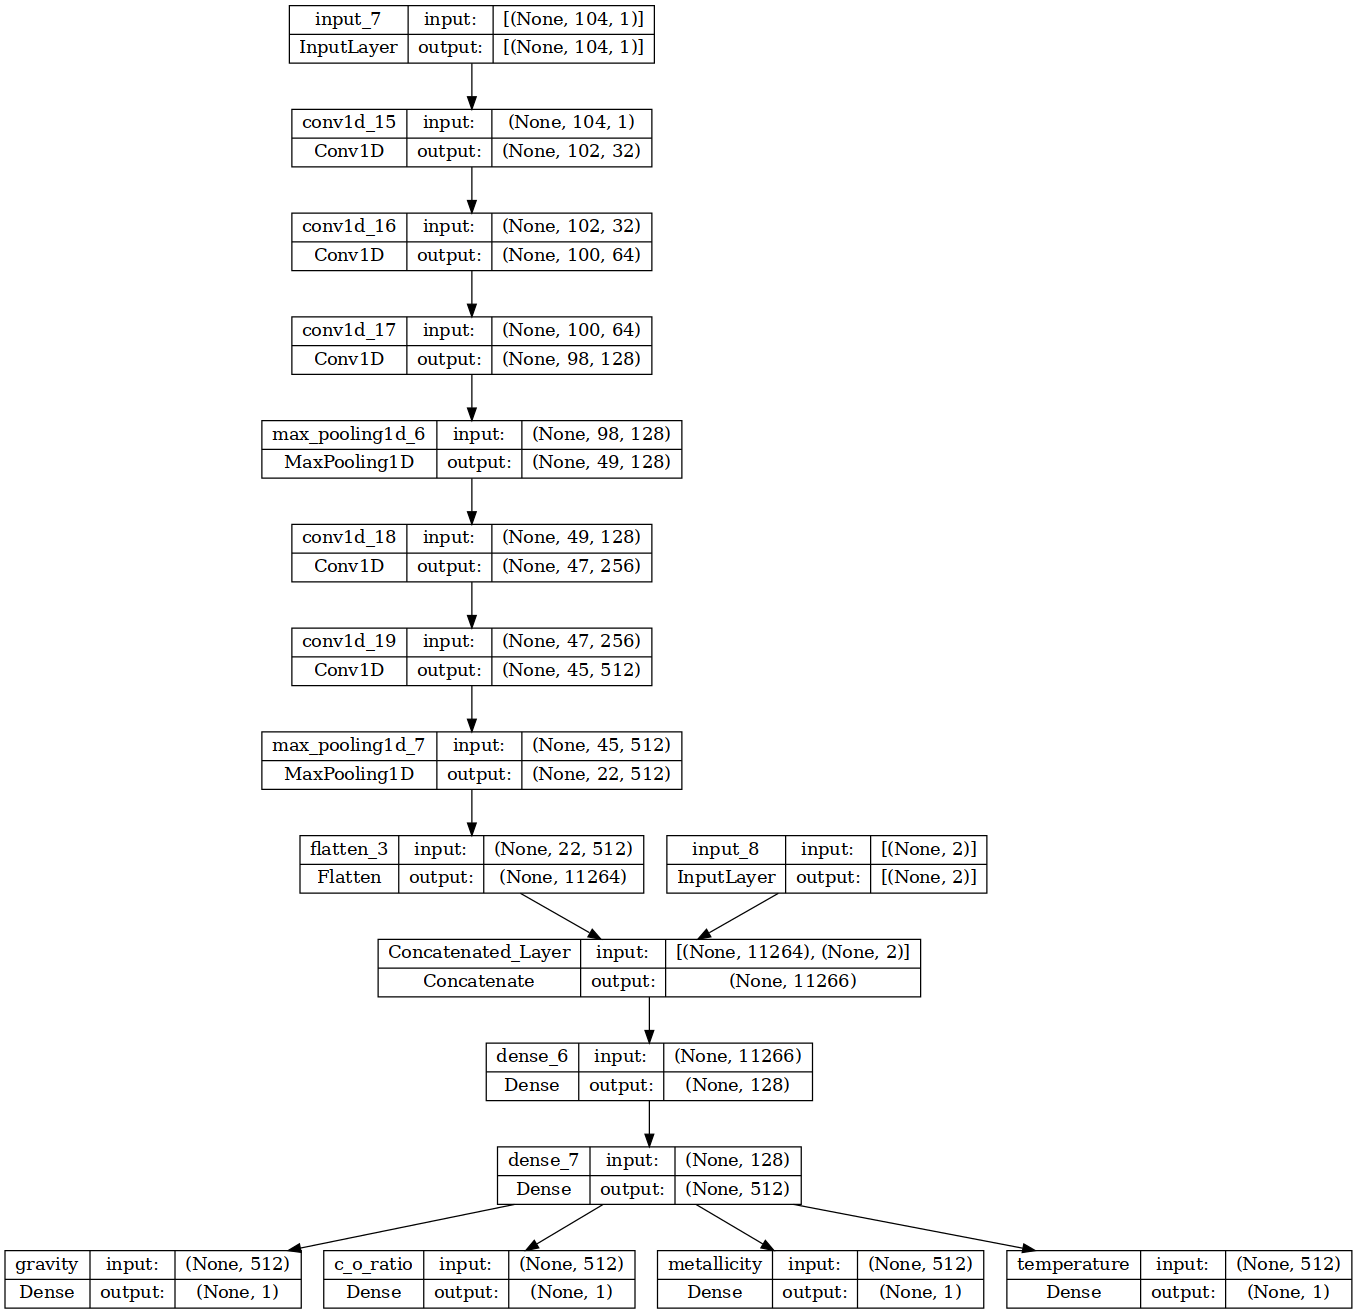

In [27]:
tf.keras.utils.plot_model(
                train_cnn_regression.trained_model,
                # to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
                show_layer_activations=False,
)

In [28]:
train_cnn_regression.trained_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 104, 1)]     0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 102, 32)      128         ['input_7[0][0]']                
                                                                                                  
 conv1d_16 (Conv1D)             (None, 100, 64)      6208        ['conv1d_15[0][0]']              
                                                                                                  
 conv1d_17 (Conv1D)             (None, 98, 128)      24704       ['conv1d_16[0][0]']              
                                                                                            

In [29]:
train_cnn_regression.plot_model_loss(title = 'X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### Plot Y predicted vs Y_Actual: Histogram & Scatter plot

1/1 [==============================] - 1s 636ms/step


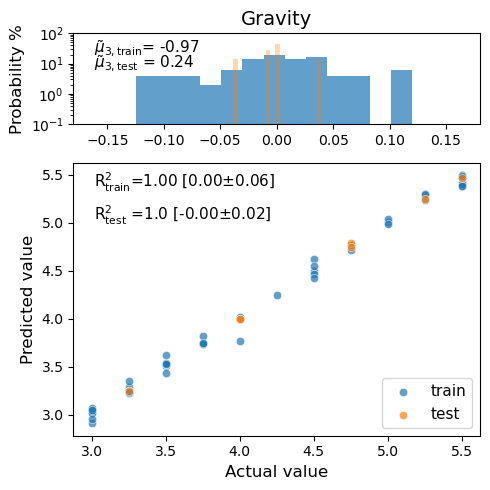

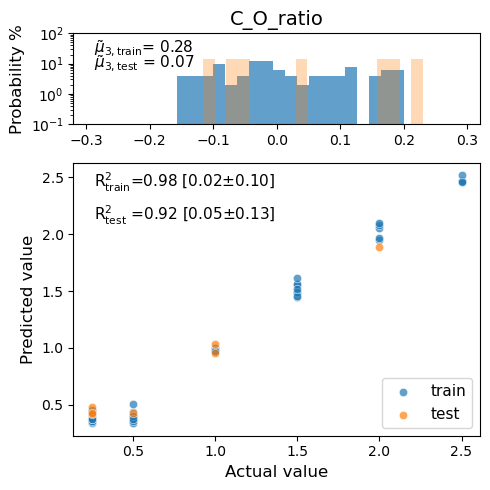

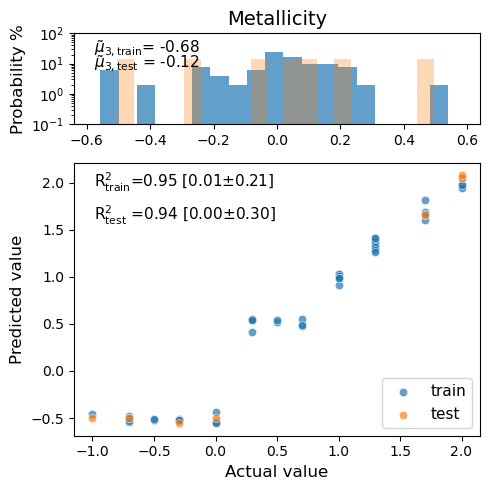

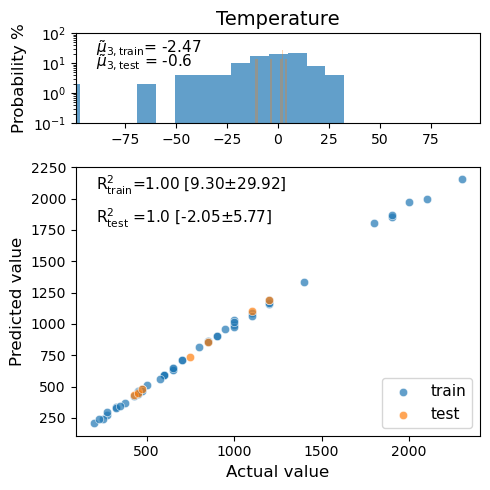

In [30]:
i = 509
regression_report(
        trained_model = train_cnn_regression,
    
        Xtrain = [train_cnn_regression.X_train_standardized_rowwise[::i],
                  train_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [train_cnn_regression.X_test_standardized_rowwise[::i], 
                  train_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = train_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = train_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )

# Step 5: Predict Observational data using the trained model

## ROSS 458C

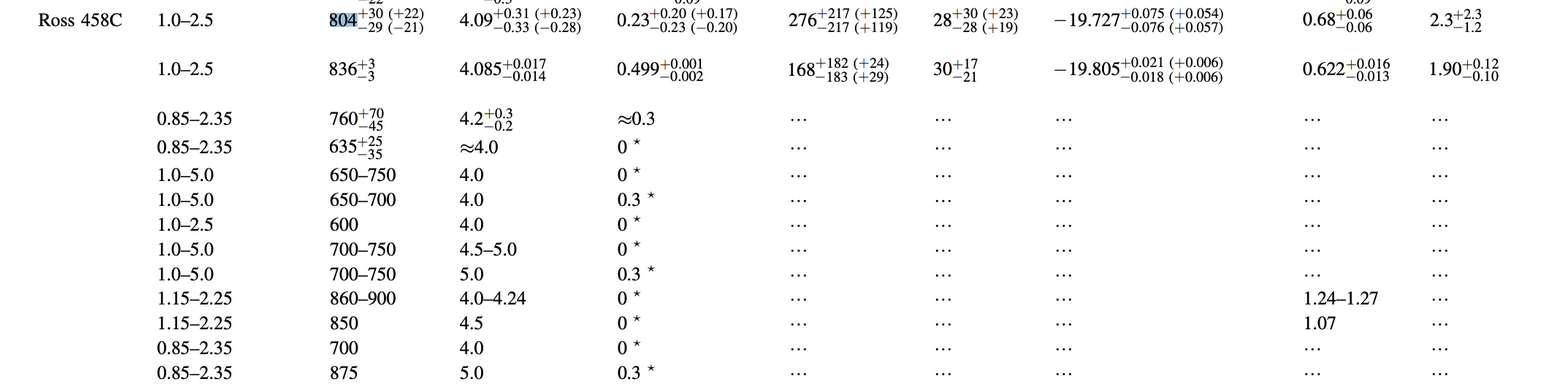

---

In [36]:
predict = ObsParameterPredictor(object_name = 'GJ570D', #Ross458C, HD3651B, GJ570D
                                dataset = df,
                                wl = wl, 
                                train_cnn_regression_class = train_cnn_regression,
                                object_radius = 50.,
                                )

In [37]:
predict.load_observational_spectra()

wl      F_lambda  F_lambda_error
0    0.657971  4.569383e-17    7.119990e-17
1    0.660155  4.581152e-17    7.119990e-17
2    0.662332  4.592921e-17    7.119990e-17
3    0.664501  4.604690e-17    7.962084e-17
4    0.666665  4.616459e-17    8.804178e-17
..        ...           ...             ...
555  2.548700  6.909362e-17    5.281551e-17
556  2.551630  7.652011e-17    6.939810e-17
557  2.554570  5.767152e-17    6.939810e-17
558  2.557520  3.882293e-17    5.212051e-17
559  2.560490  1.997433e-17    3.484292e-17

[560 rows x 3 columns]

Loading BokehJS ...

In [38]:
predict.obs_data

wl      F_lambda  F_lambda_error
0    0.657971  4.569383e-17    7.119990e-17
1    0.660155  4.581152e-17    7.119990e-17
2    0.662332  4.592921e-17    7.119990e-17
3    0.664501  4.604690e-17    7.962084e-17
4    0.666665  4.616459e-17    8.804178e-17
..        ...           ...             ...
555  2.548700  6.909362e-17    5.281551e-17
556  2.551630  7.652011e-17    6.939810e-17
557  2.554570  5.767152e-17    6.939810e-17
558  2.557520  3.882293e-17    5.212051e-17
559  2.560490  1.997433e-17    3.484292e-17

[560 rows x 3 columns]

In [39]:
predict.Process_Observational_Dataset()

50.0


******************************

Predicted Targets:
{   'c_o_ratio': 1.8196377,
    'gravity': 5.4231606,
    'metallicity': -0.39281884,
    'temperature': 822.31433}
******************************



/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:314: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:390: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)


[5.25, 5.5] [1.8196377] [800, 850] [-0.5, -0.3]


/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:465: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:538: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)


2.512         2.487         2.462         2.438         2.413  \
0  1.531006e-08  1.819078e-08  1.710700e-08  1.193964e-08  8.877562e-09   

          2.389         2.366         2.342         2.319         2.296  ...  \
0  5.420021e-09  4.008042e-09  2.408190e-09  5.287901e-09  2.940013e-09  ...   

          0.933         0.924         0.915         0.906         0.897  \
0  5.550168e-09  8.015108e-09  6.982186e-09  5.213234e-09  3.025671e-09   

    gravity  metallicity  c_o_ratio  temperature  is_augmented  
0  5.423161    -0.392819   1.819638   822.314331            no  

[1 rows x 109 columns]

2.512         2.487         2.462         2.438         2.413  \
0  4.782163e-12  5.507312e-12  4.205100e-12  4.651774e-12  3.073974e-12   

          2.389         2.366         2.342         2.319         2.296  ...  \
0  2.140121e-12  2.187066e-12  2.043812e-12  1.671057e-12  1.900468e-12  ...   

          0.981         0.971         0.962         0.952         0.943  \
0  7.268925e-12  4.852402e-12  3.604259e-12  3.243811e-12  3.422807e-12   

          0.933         0.924         0.915         0.906         0.897  
0  1.829716e-12  2.922009e-12  2.652766e-12  2.149678e-12  1.817557e-12  

[1 rows x 104 columns]

50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
******************************

Predicted Targets:
{   'c_o_ratio': 1.8196377,
    'gravity': 5.4231606,
    'metallicity': -0.39281884,
    'temperature': 822.31433}
******************************



logg        c_o        met           T
count  10.000000  10.000000  10.000000   10.000000
mean    5.289565   1.766986  -0.398499  778.660339
std     0.145570   0.230658   0.049792   27.561857
min     5.103360   1.503607  -0.483488  739.731873
25%     5.189701   1.594507  -0.419398  756.653000
50%     5.254189   1.721726  -0.402366  778.574615
75%     5.397693   1.904920  -0.366398  802.466476
max     5.528262   2.251717  -0.308992  810.925293

<Figure size 640x480 with 0 Axes>

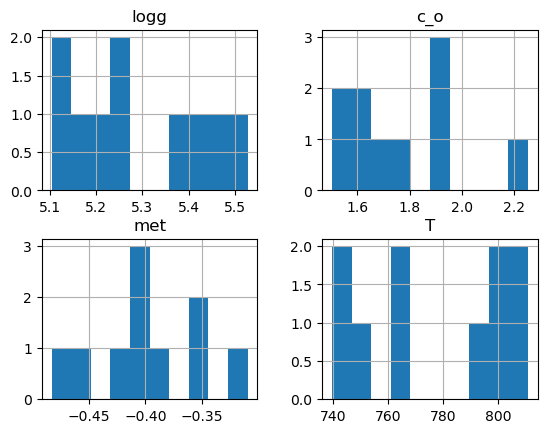

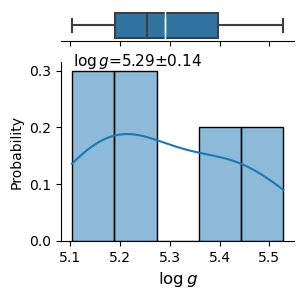

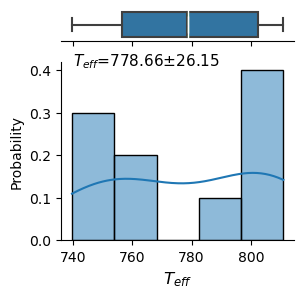

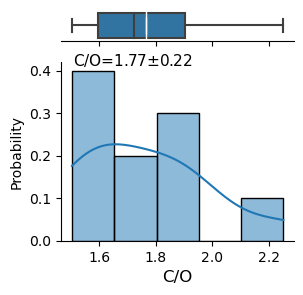

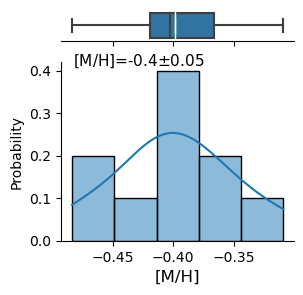

[5.25, 5.5] [1.7669864892959595] [750, 800] [-0.5, -0.3]


/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:314: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:390: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/

2.512         2.487         2.462         2.438         2.413  \
0  1.143317e-08  1.361086e-08  1.261735e-08  8.418481e-09  6.109560e-09   

          2.389         2.366         2.342         2.319         2.296  ...  \
0  3.577513e-09  2.586924e-09  1.486911e-09  3.478415e-09  1.812757e-09  ...   

          0.933         0.924         0.915         0.906         0.897  \
0  3.865196e-09  6.012598e-09  5.273711e-09  3.935097e-09  2.238196e-09   

    gravity  metallicity  c_o_ratio  temperature  is_augmented  
0  5.289565    -0.398499   1.766986   778.660339            no  

[1 rows x 109 columns]

2.512         2.487         2.462         2.438         2.413  \
0  4.782163e-12  5.507312e-12  4.205100e-12  4.651774e-12  3.073974e-12   

          2.389         2.366         2.342         2.319         2.296  ...  \
0  2.140121e-12  2.187066e-12  2.043812e-12  1.671057e-12  1.900468e-12  ...   

          0.981         0.971         0.962         0.952         0.943  \
0  7.268925e-12  4.852402e-12  3.604259e-12  3.243811e-12  3.422807e-12   

          0.933         0.924         0.915         0.906         0.897  
0  1.829716e-12  2.922009e-12  2.652766e-12  2.149678e-12  1.817557e-12  

[1 rows x 104 columns]

/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:314: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:390: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)
/data2/ehsan_storage/telescopeML_project/telescopeML/

[5.25, 5.5] [1.7669864892959595] [750, 800] [-0.5, -0.3]


/data2/ehsan_storage/telescopeML_project/telescopeML/notebooks/../telescopeML/StatVisAnalyzer.py:538: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated_all = df_interpolated_.append(df_interpolated_all, ignore_index=True)


2.512         2.487         2.462         2.438         2.413  \
0  1.143317e-08  1.361086e-08  1.261735e-08  8.418481e-09  6.109560e-09   

          2.389         2.366         2.342         2.319         2.296  ...  \
0  3.577513e-09  2.586924e-09  1.486911e-09  3.478415e-09  1.812757e-09  ...   

          0.933         0.924         0.915         0.906         0.897  \
0  3.865196e-09  6.012598e-09  5.273711e-09  3.935097e-09  2.238196e-09   

    gravity  metallicity  c_o_ratio  temperature  is_augmented  
0  5.289565    -0.398499   1.766986   778.660339            no  

[1 rows x 109 columns]

2.512         2.487         2.462         2.438         2.413  \
0  4.782163e-12  5.507312e-12  4.205100e-12  4.651774e-12  3.073974e-12   

          2.389         2.366         2.342         2.319         2.296  ...  \
0  2.140121e-12  2.187066e-12  2.043812e-12  1.671057e-12  1.900468e-12  ...   

          0.981         0.971         0.962         0.952         0.943  \
0  7.268925e-12  4.852402e-12  3.604259e-12  3.243811e-12  3.422807e-12   

          0.933         0.924         0.915         0.906         0.897  
0  1.829716e-12  2.922009e-12  2.652766e-12  2.149678e-12  1.817557e-12  

[1 rows x 104 columns]

Loading BokehJS ...

confidence_level_lower  confidence_level_upper          mean  \
2.511960            1.799591e-12            2.525229e-12  2.162410e-12   
2.486966            1.839157e-12            2.314916e-12  2.077037e-12   
2.462220            2.358045e-12            2.890250e-12  2.624148e-12   
2.437720            2.784665e-12            3.196049e-12  2.990357e-12   
2.413464            1.631345e-12            2.037692e-12  1.834518e-12   
...                          ...                     ...           ...   
0.933378            3.323648e-12            3.935973e-12  3.629810e-12   
0.924091            5.262114e-12            7.244105e-12  6.253109e-12   
0.914896            4.485627e-12            5.854856e-12  5.170241e-12   
0.905792            7.195251e-12            1.079994e-11  8.997594e-12   
0.896780            8.013321e-12            1.154087e-11  9.777094e-12   

            std_values        wl  
2.511960  5.071859e-13  2.511960  
2.486966  3.325327e-13  2.486966  
2.462220  3.719860e-13  2.462220  
2.437720  2.875375e-13  2.437720  
2.413464  2.840174e-13  2.413464  
...                ...       ...  
0.933378  4.279857e-13  0.933378  
0.924091  1.385316e-12  0.924091  
0.914896  9.570252e-13  0.914896  
0.905792  2.519502e-12  0.905792  
0.896780  2.465585e-12  0.896780  

[104 rows x 5 columns]

In [40]:
predict.predict_from_random_spectra(random_spectra_num= 10,
                                    print_results_= True,
                                    plot_randomly_generated_spectra__= True,
                                    plot_histogram_= True,
                                    plot_boxplot_hist_= True,
                                    plot_predicted_vs_observed_= True,
                                    plot_predicted_vs_spectra_errorbar_= True,
                                    plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar_ = True,
                                    calculate_confidence_intervals_std_df_=True,
                                    )

# Optimize the Radius

In [47]:
predict.bd_object.bd

{'bd_name': 'GJ570D',
 'bd_Teff': '818',
 'bd_logg': '3.94',
 'bd_met': '-0.22',
 'bd_distance_pc': 5.884,
 'bd_radius_Rjup': 3}

In [49]:
predict.bd_object.bd['bd_radius_Rjup'] = 10

---

# END ------